# Fractopo – Trace Data Validation

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import geopandas as gpd

In [3]:
from fractopo.tval.trace_validation import Validation
import matplotlib.pyplot as plt
plt.close()

## Data (KB7)

In [4]:
# Trace and target area data available on GitHub
trace_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB7/KB7_traces.geojson"
area_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB7/KB7_area.geojson"

# Use geopandas to load data from urls
traces = gpd.read_file(trace_data_url)
area = gpd.read_file(area_data_url)

# Name the dataset
name = "KB7"

## Validation (KB7)

In [5]:
# Create validation object with fixing (i.e. modification of data) allowed.
kb7_validation = Validation(traces, area, name=name, allow_fix=True)

In [6]:
# Run actual validation and capture the outputted validated trace GeoDataFrame
kb7_validated = kb7_validation.run_validation()

## Validation results (KB7)

In [7]:
# Normal DataFrame methods are available for data inspection
kb7_validated.columns

Index(['Name', 'Shape_Leng', 'geometry', 'VALIDATION_ERRORS'], dtype='object')

In [8]:
# Convert column data to string to allow hashing and return all unique
# validation errors.
kb7_validated["VALIDATION_ERRORS"].astype(str).unique()

array(['[]', "['SHARP TURNS']", "['MULTI JUNCTION']",
       "['TRACE UNDERLAPS TARGET AREA']"], dtype=object)

In [9]:
# Better description function is found in fractopo.cli
from fractopo.cli import describe_results
describe_results(kb7_validated, kb7_validation.ERROR_COLUMN)

Out of 240 traces, 8 were invalid.
There were 3 error types. These were:
MULTI JUNCTION
TRACE UNDERLAPS TARGET AREA
SHARP TURNS



The KB7 dataset contains the above errors of which `MULTI JUNCTION` and `TRACE UNDERLAPS TARGET AREA` are disruptive in further analysis.

See documentation: https://nialov.github.io/fractopo/validation/errors.html

## Visualization of errors in notebook

Though visualization here is possible, GIS-software (e.g. QGIS, ArcGIS) are much more interactive and are recommended for actual fixing and further error inspection.

### MULTI JUNCTION

In [11]:
# Find MULTI JUNCTION erroneous traces in GeoDataFrame
kb7_multijunctions = kb7_validated.loc[
    ["MULTI JUNCTION" in err for err in kb7_validated[kb7_validation.ERROR_COLUMN]]
]
kb7_multijunctions

,Name,Shape_Leng,geometry,VALIDATION_ERRORS
168,None,4.985900,"LINESTRING (466023.424 6692098.176, 466024.252...",[MULTI JUNCTION]
171,None,1.541532,"LINESTRING (466024.020 6692098.386, 466023.703...",[MULTI JUNCTION]
219,None,0.619474,"LINESTRING (466023.571 6692097.978, 466023.802...",[MULTI JUNCTION]


<AxesSubplot:>

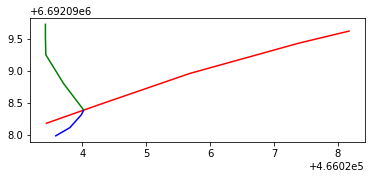

In [12]:
kb7_multijunctions.plot(colors=["red", "green", "blue"])

The plot shows that the green and blue traces abut at their endpoints
which is not a valid topology for traces.
The fix is done by merging the green and blue traces.

<AxesSubplot:>

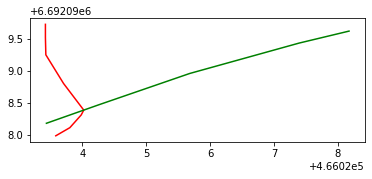

In [13]:
# Example fix
from shapely.ops import linemerge
gpd.GeoSeries(
    [
        linemerge(
            [kb7_multijunctions.geometry.iloc[1], kb7_multijunctions.geometry.iloc[2]]
        ),
        kb7_multijunctions.geometry.iloc[0]
    ]
).plot(colors=["red", "green"])

### TRACE UNDERLAPS TARGET AREA

In [14]:
# Find TRACE UNDERLAPS TARGET AREA erroneous traces in GeoDataFrame
kb7_underlaps = kb7_validated.loc[
    ["TRACE UNDERLAPS TARGET AREA" in err for err in kb7_validated[kb7_validation.ERROR_COLUMN]]
]
kb7_underlaps

,Name,Shape_Leng,geometry,VALIDATION_ERRORS
207,None,0.679687,"LINESTRING (466025.246 6692096.378, 466025.377...",[TRACE UNDERLAPS TARGET AREA]


(6692095.263678445, 6692096.877513003)

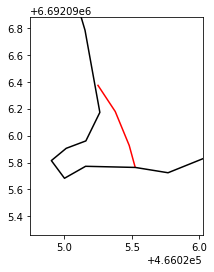

In [15]:
# Create figure, ax base
fig, ax = plt.subplots()

# Plot the underlapping trace along with the trace area boundary
kb7_underlaps.plot(ax=ax, color="red")
area.boundary.plot(ax=ax, color="black")

# Get trace bounds
minx, miny, maxx, maxy  = kb7_underlaps.total_bounds

ax.set_xlim(minx -0.5, maxx+0.5)
ax.set_ylim(miny-0.5, maxy+0.5)

The plot shows that the trace underlaps the target area at least on the northern end and maybe on the southern end. The fix is implemented by extending the trace to meet the target area boundary.